It's been reccomended that I switch from Buzzard v1.0 to 1.1. There's a nice catalog that actually has the richnesses and the masses. Huzzah.

In [73]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [74]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_redmapper_v6.4.7_lgt-1_lambda_chisq_catalog.fit')

In [75]:
data = hdulist[1].data
data.columns.info()

name:
    ['HALOID', 'RA', 'DEC', 'Z', 'M200', 'R200', 'MEM_MATCH_ID', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', 'E', 'D', 'D', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', '21E', '21E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [76]:
import numpy as np
mass = data['M200']
logMass = np.log10(mass)
rich = data['LAMBDA_CHISQ']
logRich = np.log10(rich)

#sns.jointplot(rich, logMass, kind = 'kde', space = 0, stat_func = None)

In [77]:
print 'Joint plot of Mass and Richness on a Log-Log Scale'
#Takes a long time to plot
#sns.jointplot(logRich, logMass, kind = 'kde', space = 0, stat_func = None)

Joint plot of Mass and Richness on a Log-Log Scale


Looking at the above plot, we see a few interesting things. Firstly, both richness and mass are heavily weighted at lower values. Secondly, the spread of values is pretty significant. Imaginging taking any 1-D slice along a richness value leaves almost an order of magnitude possible masses. I think it's somewhat clear that richness is a generally poor predictor of mass. 

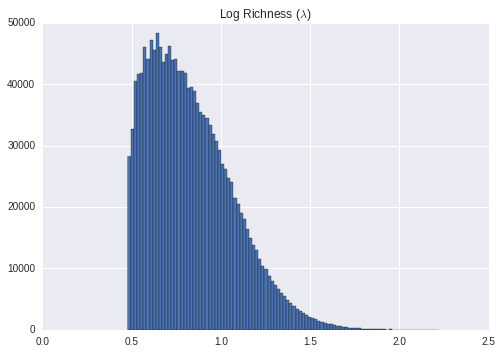

In [78]:
plt.hist(logRich, bins = 100);
plt.title('Log Richness ($\lambda$)')

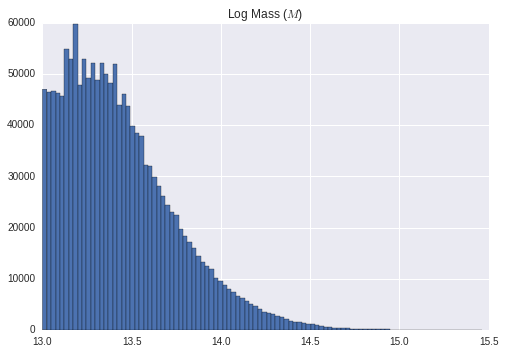

In [79]:
plt.hist(logMass, bins = 100);
plt.title('Log Mass ($M$)')

Mass seems to have a floor of 10^13 Solar masses, which seems reasonable but may have to be factored into the mass function. 

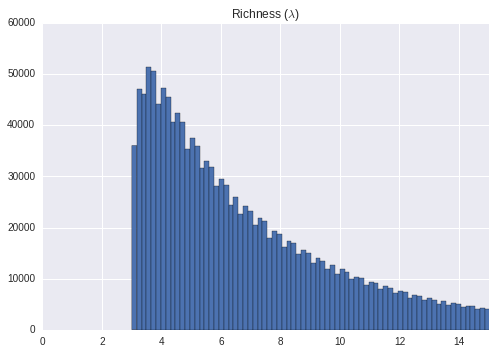

In [80]:
plt.hist(rich, bins = 1000);
plt.title('Richness ($\lambda$)')
plt.xlim(0,15);

Richness seems to be truncated at 3, which is much lower than the truncation at 20 in Buzzard 1.0. It seems like the distribution is going back down below ~4, which is interesting. I wonder what richness really means at low values. Does a lone galaxy in space really have a richness of 1? And though the distribution is fairly smooth, there is clearly some higher order structure. Let me blow that up a little bigger. 

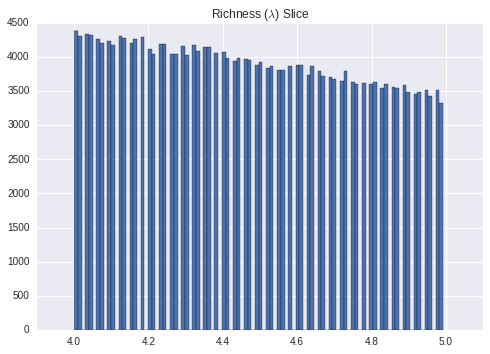

In [81]:
s1 = rich[rich>4.0]
s2 = s1[s1<5.0]
plt.hist(s2, bins = 100);
plt.title('Richness ($\lambda$) Slice')
plt.xlim(3.9,5.1);

Wow, that is some really weird structure. I have no idea if that's being exacerbated by the type of binning I'm doing. I also don't know if this is going to affect our analysis in any way. 

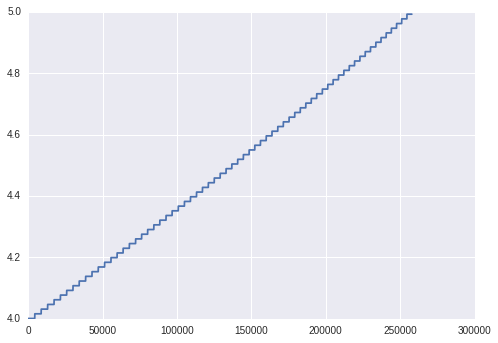

In [82]:
plt.plot(sorted(s2))

Well that explains it; it's just a resolution issue. Still may have to be accounted for because that shows up in weird ways. 

The simplest type of regression that we can do is a linear regression on the log space data. I do that below. The parameters a,b are for the model $\lambda =  a\;M^b$.

In [83]:
from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

a: 9.418e-05	b: 3.615e-01
R^2: 0.225


Somewhat what I expected. We have semi-reasonable values, but we're only accounting for 22% of our error. Those are some serious astronomy regression numbers. Let's see how it reproduces the distribution. 

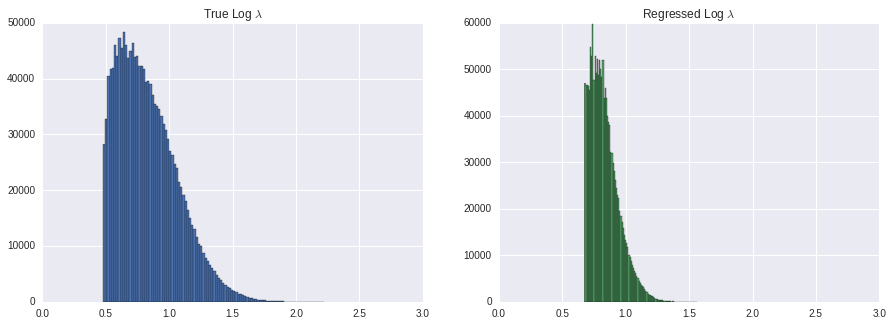

In [84]:
from itertools import cycle
palette = cycle(sns.color_palette())
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 100
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);

Approximately the same shape, but the scale's all wrong. Let's see if we can find that higher order structure from earlier. Note how I'm bumping up the bin size. 

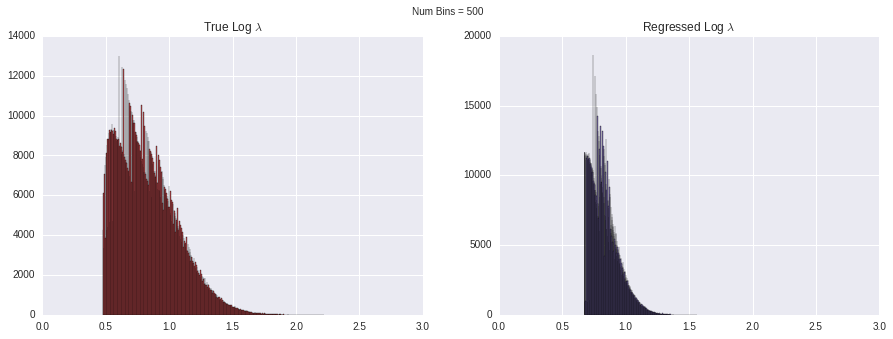

In [85]:
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 500
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);
plt.suptitle('Num Bins = %d'%nBins)

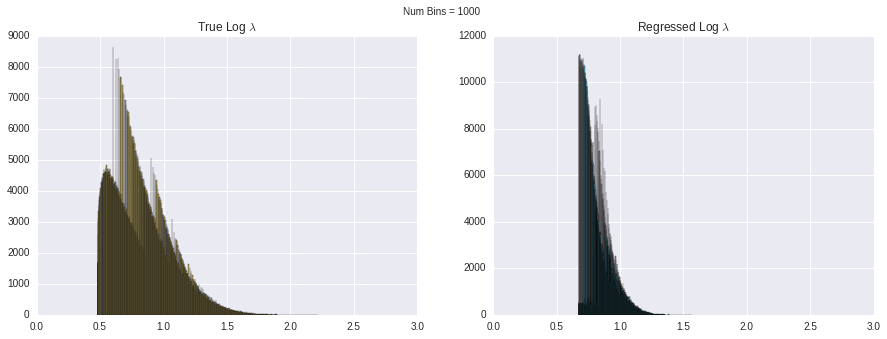

In [86]:
#nBins = int(np.sqrt(rich.shape[0]))
nBins = 1000
xlims = [0,3]
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('True Log $\lambda$')
plt.hist(logRich, bins = nBins, color = next(palette));
plt.xlim(xlims)
plt.subplot(122)
plt.title('Regressed Log $\lambda$')
A = 10**logA
plt.hist(logA+b*np.log10(data['M200']),bins = nBins, color = next(palette));
plt.xlim(xlims);
plt.suptitle('Num Bins = %d'%nBins)

Whoa. those are just straight weird looking. I think we might want to pause and thing about how this is affecting things. 

Ok, now I'm going to try to do inference on these to see if I recover the same weird behavior I had before, making use of these true masses that I have. I'll show a PGM of the simplest case that eliminates use of the mass function altogether, assuming masses are perfcetly known. 

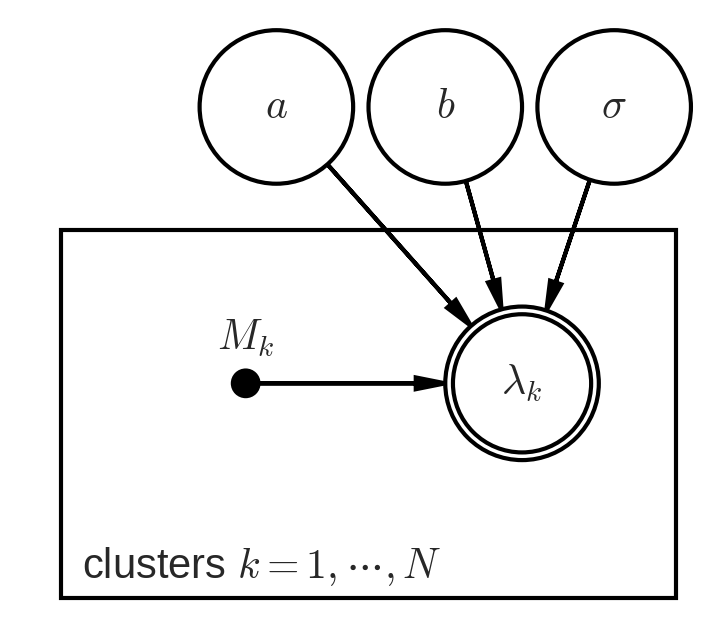

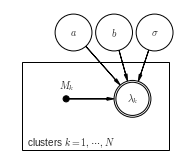

In [87]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

#pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

#pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,.85,fixed =True))
#pgm.add_node(daft.Node("class", r"$c_k$", 0.7, 1.35, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1, fixed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

#pgm.add_edge("redshift", "Mcluster")
#pgm.add_edge("class", "Mcluster")
#pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM3.png", dpi = 300)
from IPython.display import Image
Image("modelPGM3.png")

This has the distribution:

$P(a,b,\sigma | \{M\}, \{\lambda\}) = \prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma) P(a,b,\sigma)\;} $

In [88]:
from scipy.stats import gamma
def log_prior(a,b,sigma):
    
    if any(x<0 for x in (a,sigma)):
        return -np.inf
    t = np.arctan(b)
    if t<0 or t>np.pi/2:
        return -np.inf
    
    #Hyperparameters
    lambda_a = 1
    sigma_a, sigma_b = 1,1
    p = 0

    #Exponential in log a
    p+= np.log(lambda_a)+lambda_a*np.log(a)
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

norms = {}
def log_liklihood(rich, M, a,b,sigma):
    p = 0

    p-= np.sum(((b*np.log(a*M)-np.log(rich))**2)/(2*sigma**2)-np.log(sigma*rich))
    return p

def log_posterior(theta,rich, M):
    #print theta
    a,b,sigma = theta[:]
    #a = a*1e-11 #rescale
    p = log_prior(a,b,sigma)
    if np.isfinite(p):
        p+=log_liklihood(rich,M,a,b,sigma)
    #print '-'*50
    return p

In [89]:
ndim = 3
nwalkers = 1000

a_mean, a_spread = 1e-11, 2e-12
#a_mean, a_spread = 1, .1#rescale in liklihood
b_mean, b_spread = 1, .2
sigma_mean, sigma_spread = 1, .5

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:
    #a,b,sigma,m
    row[0] = a_mean+np.random.randn()*a_spread
    row[1] = b_mean+np.random.randn()*b_spread
    sig_try = -1
    while sig_try < 0:
        sig_try = sigma_mean+np.random.randn()*sigma_spread
    row[2] = sig_try

In [90]:
import emcee as mc
import multiprocessing
nCores = multiprocessing.cpu_count()
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, mass],threads = nCores)
nsteps, nburn = 100, 200

In [91]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

In [92]:
chain = sampler.flatchain[nburn:, :]
#sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
del(sampler)

MAP = chain.mean(axis = 0)
print MAP

[  1.95355727e-04   2.67215417e+07   2.40132936e+08]


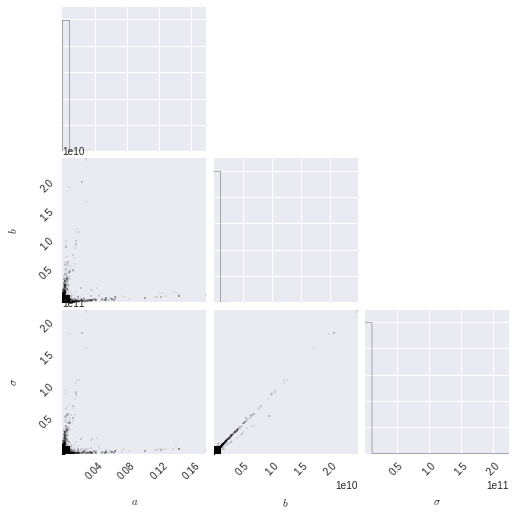

In [93]:
from corner import corner
titles = ['$a$', '$b$', '$\sigma$']
corner(chain, labels = titles);# , truths = [a_true, b_true, sigma_true]);